In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Añadir la carpeta principal del repo al path
sys.path.append(os.path.abspath(".."))

LAPTOP = True
if LAPTOP == True:
    path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'
    event = 'event000001000'
    hits, cells, particles, truth = load_event(path + event)

if LAPTOP == False:
    path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
    event = 'event000001000'

print('Loading event {}'.format(path + event))

hits, cells, particles, truth = load_event(path + event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /mnt/d/TFG - Dataset/DATASET/train_1/event000001000
event000001000 memory usage 18.46 MB


# Búsqueda de pares prometedores

In [2]:
# #============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#
# from commonMLfunctions import hits_vertex
# hits, cells, particles, truth = load_event(path+event)
# hits, particles = hits_vertex(hits, particles, truth)

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from kalman_filter import get_hits_dict
from commonMLfunctions import hits_vertex, generate_triplets_from_hits

PARTICLES_FROM_VERTEX = True  # Si se quiere usar los hits de la parte central del detector
N_events = 100
events = []
for i in range(0, N_events+1):
    event = f'event000001{i:03d}'
    events.append(event)
#events = ['event000001000', 'event000001001', 'event000001002']
print(events)
print(f"Procesando {len(events)} eventos: {events}")


const_base_angle_rad = np.deg2rad(2.0)
base_angle_fn = lambda z_array: np.full_like(z_array, const_base_angle_rad)


for event in events:
    print(f"\n========================= Procesando evento: {event} =========================\n")
    data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
    output_path = os.path.join(data_dir, f'triplets_data_{event}_precise.npz')


    #cone_angle = np.deg2rad(4)  # en vez de 0.5°

    def angle(v1, v2):
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.arccos(np.clip(cos_theta, -1.0, 1.0))

    # triplets = []
    # labels = []
    # pt_values = []

    if os.path.exists(output_path):
        print(f"El archivo {output_path} ya existe. Cargando datos preprocesados...")
        #data = np.load(output_path, allow_pickle=True)
        #X = data['X']
        #y = data['y']
        # Si el archivo ya tiene pt, lo cargas también:
        #if 'pt' in data:
        #    pt_values = data['pt']
        #print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")
        #scaler = data['scaler'].item()  # allow_pickle=True permite .item()
        #print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")



    else:
        print(f"El archivo {output_path} no existe. Generando triplets...")
        hits, cells, particles, truth = load_event(path + event)

        hits, particles = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX= PARTICLES_FROM_VERTEX)

        from commonMLfunctions import generate_triplets_from_hits, filtering_by_theta

        # Filtrado de hits por theta
        thetamin, thetamax = filtering_by_theta(hits)

        # Selección de volúmenes
        volume_ids = hits['volume_id'].unique()
        volume_ids = volume_ids[[1, 4, 7]]  
        first_volume = volume_ids[0]

        hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=(-round(thetamin), round(thetamax)), pt_range = (0.5, np.inf))
        #print(particles.head())
        pt_dict = dict(zip(particles['particle_id'], particles['pt']))  # Cambia 'pt' por el nombre correcto si es diferente

        # Capas
        first_layer = sorted(hits_dict[first_volume].keys())[0]
        second_layer = sorted(hits_dict[first_volume].keys())[1]
        third_layer = sorted(hits_dict[first_volume].keys())[2]

        print('PRECAUCIÓN')
        print(first_layer, second_layer, third_layer)

        layer1 = hits_dict[first_volume][first_layer]
        layer2 = hits_dict[first_volume][second_layer]
        layer3 = hits_dict[first_volume][third_layer]

        coords1 = layer1[['x', 'y', 'z']].values
        coords2 = layer2[['x', 'y', 'z']].values
        coords3 = layer3[['x', 'y', 'z']].values

        ids1 = layer1['particle_id'].values
        ids2 = layer2['particle_id'].values
        ids3 = layer3['particle_id'].values

        hits_filtered = pd.concat([layer1, layer2, layer3])
        hits_filtered['n_event'] = event  
        hits_filtered['layer'] = 0
        hits_filtered.loc[hits_filtered.index.isin(layer2.index), 'layer'] = 1
        hits_filtered.loc[hits_filtered.index.isin(layer3.index), 'layer'] = 2

        # Nos aseguramos que hits_filtered tenga columnas necesarias
        assert all(col in hits_filtered.columns for col in ['x', 'y', 'z', 'particle_id', 'pt', 'layer'])

        # Generar tripletes
        X, y, pt_values = generate_triplets_from_hits(
            hits_filtered,
            pt_min=0.5,
            pt_max=np.inf,  
        )

        print(f"Sin balanceo: Positivos = {np.sum(y == 1)}, Negativos = {np.sum(y == 0)}")

        # Guardar
        X_original = X.reshape(X.shape[0], -1)
        #X_original = X

        np.savez(output_path, 
                X=X_original,
                y=y,
                pt=pt_values)

        file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"Datos guardados en {output_path}.\n\tTamaño del archivo generado: {file_size_mb:.2f} MB")

        # Liberamos RAM:
        del hits, cells, particles, truth
        del hits_filtered, X, y, pt_values, X_original
        del layer1, layer2, layer3, coords1, coords2, coords3
        del ids1, ids2, ids3
        import gc
        gc.collect()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_hits_by_volume_and_layer(hits_dict, volume_ids):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red', 'green', 'blue']
    markers = ['o', '^', 's']
    
    for v_idx, vol_id in enumerate(volume_ids):
        volume_hits = hits_dict[vol_id]
        for l_idx, layer in enumerate(sorted(volume_hits.keys())):
            layer_hits = volume_hits[layer]
            ax.scatter(
                layer_hits['x'], layer_hits['y'], layer_hits['z'],
                color=colors[v_idx],
                marker=markers[l_idx % len(markers)],
                label=f'Volume {vol_id}, Layer {layer}',
                s=5,
                alpha=0.6
            )

    ax.set_title('Hits por Volumen y Capa')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=90, azim=-60)
    ax.legend()
    plt.tight_layout()
    plt.show()

#plot_hits_by_volume_and_layer(hits_dict, volume_ids)

module://matplotlib_inline.backend_inline
@common.py:  
	set random seed
		SEED=35202
	set cuda environment
		torch.__version__              = 2.7.1+cu126
		torch.version.cuda             = 12.6
		torch.backends.cudnn.version() = 90501
		os['CUDA_VISIBLE_DEVICES']     = None
		torch.cuda.device_count()      = 1
		torch.cuda.current_device()    = 0

['event000001000', 'event000001001', 'event000001002', 'event000001003', 'event000001004', 'event000001005', 'event000001006', 'event000001007', 'event000001008', 'event000001009', 'event000001010', 'event000001011', 'event000001012', 'event000001013', 'event000001014', 'event000001015', 'event000001016', 'event000001017', 'event000001018', 'event000001019', 'event000001020', 'event000001021', 'event000001022', 'event000001023', 'event000001024', 'event000001025', 'event000001026', 'event000001027', 'event000001028', 'event000001029', 'event000001030', 'event000001031', 'event000001032', 'event000001033', 'event000001034', 'event000001035', 

In [4]:
import os
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
combined_X_original = []
combined_y = []

INDIVIDUAL_EVENTS = False

N_events = 100  # Número total de eventos a combinar
# Recorre todos los archivos de tripletes
for i in range(1, N_events+1):
    event = f'event000001{i:03d}'
    path = os.path.join(data_dir, f'triplets_data_{event}_precise.npz')

    if not os.path.exists(path):
        print(f"ERROR: Archivo no encontrado: {path}")
        continue

    print(f"Cargando {path}...")
    data = np.load(path, allow_pickle=True)
    X_original = data['X']  # Datos antes del escalado
    y = data['y']

    combined_X_original.append(X_original)
    combined_y.append(y)


# Combina todos
X_all_original = np.vstack(combined_X_original)  # (N, 3, 3)
y_all = np.concatenate(combined_y)

# Aplana a (N, 9) para escalar
N = X_all_original.shape[0]
X_all_flat = X_all_original.reshape(N, -1)  # (N, 9)

# Escala con MinMaxScaler
print("Stats antes del escalado:")
print("Min X:", X_all_flat.min(), "Max X:", X_all_flat.max())

scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all_flat)

# BALANCEO GLOBAL
from sklearn.utils import resample

BALANCEO_GLOBAL = False  # Si vemos un claro desbalance de clases

if BALANCEO_GLOBAL:
    positive_idx = np.where(y_all == 1)[0]
    negative_idx = np.where(y_all == 0)[0]

    n_pos = len(positive_idx)
    n_neg = len(negative_idx)

    print(f"\nRealizando balanceo global:")
    print(f"Positivos: {n_pos}, Negativos: {n_neg}")

    if n_pos > 0 and n_neg >= n_pos:
        negative_sample = resample(negative_idx, replace=False, n_samples=n_pos, random_state=42)
        selected_idx = np.concatenate([positive_idx, negative_sample])
    elif n_neg < n_pos:
        positive_sample = resample(positive_idx, replace=False, n_samples=n_neg, random_state=42)
        selected_idx = np.concatenate([positive_sample, negative_idx])
    else:
        selected_idx = np.array([])  # No balanceable

    # Reorganizar los datos
    X_all_scaled = X_all_scaled[selected_idx]
    X_all_original = X_all_original[selected_idx]
    y_all = y_all[selected_idx]

    print(f"Después del balanceo global:\n Positivos: {np.sum(y_all==1)}, Negativos: {np.sum(y_all==0)}")
else:
    print(f"\nSin balanceo global:\n Positivos: {np.sum(y_all==1)}, Negativos: {np.sum(y_all==0)}")


print(f"\nTotal de tripletes combinados: {X_all_scaled.shape[0]}")
print(f"Positivos: {np.sum(y_all==1)}")
print(f"Negativos: {np.sum(y_all==0)}")

# Guarda el conjunto combinado escalado
combined_path = os.path.join(data_dir, 'triplets_data_combined_precise.npz')
np.savez(combined_path, X=X_all_scaled, y=y_all, triplets_original=X_all_original)
joblib.dump(scaler, os.path.join(data_dir, 'scaler_combined_precise.pkl'))

print(f"\nDatos combinados guardados en: {combined_path}")
print(f"Scaler global guardado en: {os.path.join(data_dir, 'scaler_combined_precise.pkl')}")


Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001001_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001002_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001003_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001004_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001005_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001006_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001007_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001008_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001009_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001010_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001011_precise.npz...
Cargando /mnt/d/TFG - Dataset/OUTPUT/triplets_data_event000001012_precise.npz...
Cargando /mnt/d/TFG - Datase

In [5]:
from model import TripletNet, SimpleNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from commonMLfunctions import TripletDataset, create_dataloaders
from common import *
from commonMLfunctions import write_metrics_to_log, training_triplet_model, predict_all
from sklearn.model_selection import train_test_split

%matplotlib inline

LOAD_TRAINED_MODEL = True

if not os.path.exists(combined_path):
    raise FileNotFoundError(f"No se encuentra el archivo combinado: {combined_path}")


if not LOAD_TRAINED_MODEL:
    model = SimpleNet  # Inicializa el modelo vacío
    best_f1 = 0

    print("Entrenando el modelo con tripletes combinados...")

    data = np.load(combined_path, allow_pickle=True)
    X = data['X']
    y = data['y']
    print(f"Datos cargados: X={X.shape}, y={y.shape}")
    print(f"Positivos: {np.sum(y == 1)}\tNegativos: {np.sum(y == 0)}")
    print(f"X[0] = {X[0]}")
    #pt = data['pt']
    # X = X.reshape(-1, 3, 3)
    # Tomamos un 10% estratificado para debug/entrenar rápido
    X_sub, _, y_sub, _ = train_test_split(
        X, y,
        train_size=0.4,
        stratify=y,
        random_state=42
    )
    print(f"Subset estratificado: {len(y_sub)} muestras, "
      f"Positivos: {y_sub.sum()}, Negativos: {len(y_sub)-y_sub.sum()}")

    print("DEBUG subset:", X_sub.shape)

    event = 'combined_precise'
    model = training_triplet_model(X, y, model=None)


    # Guardamos el modelo final con fecha y hora
    from datetime import datetime
    current_time = datetime.now().strftime("%m%d_%H%M%S")
    model_save_name = f'triplet_model_{current_time}.pth'

    model_save_path = os.path.join('/home/alvar/repositorioTFG/ML_trackfinding', model_save_name)

    torch.save(model.state_dict(), model_save_path)


## Evaluación del modelo final

In [6]:
import torch
from model import TripletNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from commonMLfunctions import create_dataloaders
import numpy as np
import os
import joblib  

# === Cargar el modelo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet().to(device)

if LOAD_TRAINED_MODEL:
    model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0706_200816.pth'
    model_save_path = '/home/alvar/repositorioTFG/ML_trackfinding/triplet_model_0707_001317.pth'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
else:
    model.load_state_dict(torch.load(model_save_path, map_location=device))

model.eval()

# === Cargar datos de validación ===
if not INDIVIDUAL_EVENTS:
    event = 'event000001000'
    base_path = "/mnt/d/TFG - Dataset/OUTPUT"
    file_name = f"triplets_data_{event}_precise.npz"
    data_path = os.path.join(base_path, file_name)
    data = np.load(data_path)
else:
    data = np.load(combined_path, allow_pickle=True)

# === Cargar scaler y transformar datos ===
scaler_path = os.path.join(base_path, 'scaler_combined_precise.pkl')
scaler = joblib.load(scaler_path)

# Datos: (N, 3, 3) → (N, 9)
X_triplets = data["X"]
N = X_triplets.shape[0]
X_flat = X_triplets.reshape(N, -1)           # (N, 9)
X_scaled = scaler.transform(X_flat)          # ESCALADO UNA SOLA VEZ

# Convertir a tensores
X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(data["y"]).float()

from torch.utils.data import DataLoader, TensorDataset

# === Crear DataLoader ===
full_dataset = TensorDataset(X_tensor, y_tensor)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# === Evaluación ===
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for x_batch, y_batch in full_loader:
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = (torch.sigmoid(logits) > 0.5).float().cpu()
        y_true_all.append(y_batch.cpu())
        y_pred_all.append(preds)

y_true = torch.cat(y_true_all).numpy()
y_pred = torch.cat(y_pred_all).numpy()

# === Métricas ===
print("\n=== Evaluación del modelo final ===")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))



=== Evaluación del modelo final ===
Accuracy:  0.9081
Precision: 0.8030
Recall:    0.8114
F1-score:  0.8072

Confusion Matrix:
[[3444  227]
 [ 215  925]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9412    0.9382    0.9397      3671
         1.0     0.8030    0.8114    0.8072      1140

    accuracy                         0.9081      4811
   macro avg     0.8721    0.8748    0.8734      4811
weighted avg     0.9085    0.9081    0.9083      4811



Los datos que tomo son un 29.4380% de los datos originales
Mínimo p: 0.10 GeV/c
Máximo p: 45.35 GeV/c
Número de partículas totales: 12263
Número de partículas únicas con pt<0.5 GeV/C: 1632
   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       2 -55.336102  0.635342 -1502.5          7         2          1   
1      10 -90.292900 -3.269370 -1502.5          7         2          1   
2      11 -59.182999 -0.670508 -1502.5          7         2          1   
3      13 -72.533997  2.642190 -1502.5          7         2          1   
4      15 -63.436501 -3.262220 -1502.5          7         2          1   

          particle_id         phi       theta        pt  
0   22525763437723648  179.342163  177.890640  0.569780  
1   67554956483231744  182.073685  176.558685  0.256025  
2  274720539342274560  180.649109  177.744141  0.208051  
3   63061596057894912  177.913818  177.234314  0.267059  
4   63064276117487616  182.943848  177.579178  0.201794  
Ángulo theta mínim

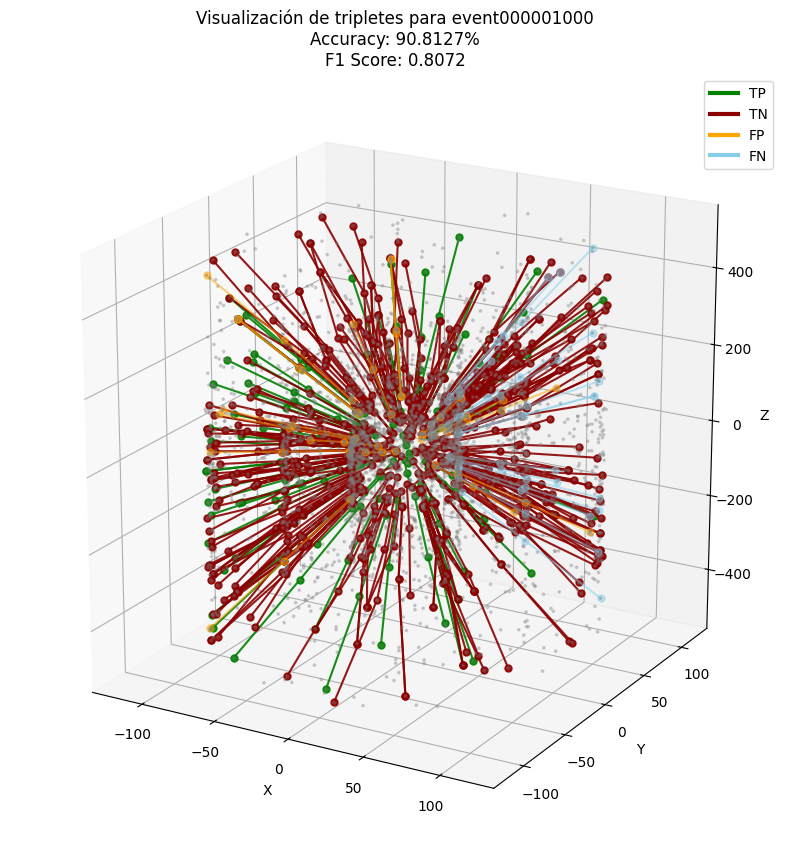

Tripletes TP desescalados guardados en: /mnt/d/TFG - Dataset/OUTPUT/triplets_tp_descaled_event000001000.npz
Total de TP guardados: 925


In [17]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import torch
import joblib
import os
from kalman_filter import filtering_by_theta

%matplotlib inline
# === Configuración ===
data_dir = "/mnt/d/TFG - Dataset/OUTPUT"
scaler_path = os.path.join(data_dir, 'scaler_combined_precise.pkl')
scaler = joblib.load(scaler_path)

path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'
event = 'event000001000'
hits, cells, particles, truth = load_event(path + event)
hits, particles = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX=True)

volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  # Volúmenes que nos interesan
first_volume = volume_ids[0]

thetamin, thetamax = filtering_by_theta(hits)
hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=(-round(thetamin), round(thetamax)), pt_range=(0.5, np.inf))

first_layer  = sorted(hits_dict[first_volume].keys())[0]
second_layer = sorted(hits_dict[first_volume].keys())[1]
third_layer  = sorted(hits_dict[first_volume].keys())[2]

layer1 = hits_dict[first_volume][first_layer]
layer2 = hits_dict[first_volume][second_layer]
layer3 = hits_dict[first_volume][third_layer]

# === Datos cargados del modelo ===
loaded = np.load(os.path.join(data_dir, f"triplets_data_{event}_precise.npz"))
X_triplets_original = loaded["X"]  # (N, 3, 3)
y_true = loaded["y"]

# === Escalado para visualización ===
N = X_triplets_original.shape[0]
X_flat = X_triplets_original.reshape(N, -1)       # (N, 9)
X_scaled = scaler.transform(X_flat)               # (N, 9) escalado

# === Predicciones del modelo ===
# Aquí asumimos que ya has evaluado el modelo y tienes `y_pred` correspondiente
# Asegúrate de que y_pred_all provenga del mismo evento y modelo
y_pred = torch.cat(y_pred_all).numpy()

# === Visualización ===
def visualize_triplets_by_accuracy_sampled(
    X_triplets_scaled, y_true, y_pred, scaler,
    layer1, layer2, layer3,
    title='Visualización por accuracy', total_to_show=100):

    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    min_len = min(len(y_true), len(y_pred), len(X_triplets_scaled))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    X_triplets_scaled = X_triplets_scaled[:min_len]

    print("X_triplets_scaled stats antes de desescalar:")
    print("Min:", X_triplets_scaled.min(), "Max:", X_triplets_scaled.max(), "Mean:", X_triplets_scaled.mean())

    X_triplets_descaled_flat = scaler.inverse_transform(X_triplets_scaled)     # (N, 9)
    X_triplets_descaled = X_triplets_descaled_flat.reshape(min_len, 3, 3)      # (N, 3, 3)

    print("X_triplets_descaled_flat stats después de desescalar:")
    print("Min:", X_triplets_descaled_flat.min(), "Max:", X_triplets_descaled_flat.max(), "Mean:", X_triplets_descaled_flat.mean())

    # === Visualización 3D ===
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(layer1.x, layer1.y, layer1.z, c='gray', alpha=0.3, s=3, label='Layer 1')
    ax.scatter(layer2.x, layer2.y, layer2.z, c='gray', alpha=0.3, s=3, label='Layer 2')
    ax.scatter(layer3.x, layer3.y, layer3.z, c='gray', alpha=0.3, s=3, label='Layer 3')

    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=20, azim=-60)

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]

    counts = {'TP': len(tp_idx), 'TN': len(tn_idx), 'FP': len(fp_idx), 'FN': len(fn_idx)}
    total = sum(counts.values())
    proportions = {k: v / total for k, v in counts.items()}
    sampled_counts = {k: max(1, int(proportions[k] * total_to_show)) for k in proportions}

    difference = total_to_show - sum(sampled_counts.values())
    if difference != 0:
        sorted_keys = sorted(counts.items(), key=lambda x: -x[1])
        for k, _ in sorted_keys:
            sampled_counts[k] += difference
            break

    sampled = {
        'TP': random.sample(list(tp_idx), min(sampled_counts['TP'], len(tp_idx))),
        'TN': random.sample(list(tn_idx), min(sampled_counts['TN'], len(tn_idx))),
        'FP': random.sample(list(fp_idx), min(sampled_counts['FP'], len(fp_idx))),
        'FN': random.sample(list(fn_idx), min(sampled_counts['FN'], len(fn_idx))),
    }

    def plot_triplets(indices, color, alpha):
        for i in indices:
            triplet = X_triplets_descaled[i]
            ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], c=color, alpha=alpha, marker='o', markersize=5)

    plot_triplets(sampled['TP'], 'green', 0.9)
    plot_triplets(sampled['TN'], 'darkred', 0.9)
    plot_triplets(sampled['FP'], 'orange', 0.5)
    plot_triplets(sampled['FN'], 'skyblue', 0.5)

    acc = (counts['TP'] + counts['TN']) / total if total else 0.0

    print(f"Original: TP={counts['TP']}, TN={counts['TN']}, FP={counts['FP']}, FN={counts['FN']}")
    print(f"Mostrando: TP={len(sampled['TP'])}, TN={len(sampled['TN'])}, FP={len(sampled['FP'])}, FN={len(sampled['FN'])}")
    print(f"Accuracy: {acc:.4%}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

    ax.set_title(f"{title}\nAccuracy: {acc:.4%}\nF1 Score: {f1_score(y_true, y_pred):.4f}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    handles = [
        plt.Line2D([0], [0], color='green', lw=3),
        plt.Line2D([0], [0], color='darkred', lw=3),
        plt.Line2D([0], [0], color='orange', lw=3),
        plt.Line2D([0], [0], color='skyblue', lw=3)
    ]
    labels = ['TP', 'TN', 'FP', 'FN']
    ax.legend(handles, labels)

    plt.show()
    return X_triplets_descaled, X_triplets_descaled_flat


# === Ejecutar visualización ===
X_triplets_descaled, X_triplets_descaled_flat = visualize_triplets_by_accuracy_sampled(
    X_scaled, y_true, y_pred, scaler,
    layer1, layer2, layer3,
    title=f'Visualización de tripletes para {event}', 
    total_to_show=400)

# === (Opcional) Guardar resultado desescalado ===
# save_path = os.path.join(data_dir, f'triplets_descaled_{event}.npz')
# np.savez(save_path, triplets=X_triplets_descaled)
# print(f"Tripletes desescalados guardados en: {save_path}")

# 1. Índices de los True Positives (TP)
tp_indices = np.where((y_true == 1) & (y_pred == 1))[0]

# 2. Filtrar los tripletes desescalados
X_tp_descaled = X_triplets_descaled[tp_indices]

# 3. Guardar solo los TP desescalados
save_path = os.path.join(data_dir, f'triplets_tp_descaled_{event}.npz')
np.savez(save_path, triplets=X_tp_descaled)

print(f"Tripletes TP desescalados guardados en: {save_path}")
print(f"Total de TP guardados: {X_tp_descaled.shape[0]}")